# Transfer Learning

---

#### Goals

1. load pre-trained model (ResNet)
2. choose layers for fine-tuning
3. Learn CIFAR-10 using your transfer learning model

---

## 1. Library Importation & Device Preparation

In [1]:
# You don't need to edit this section today.
import gc
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from IPython.display import clear_output
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchsummary import summary as Summary
from torchvision import models
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   ToPILImage, Resize, Grayscale

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## 2. Hyper-parameters

By executing below blocks, you can initialize/update hyper-parameters.

In [2]:
# Data Load
input_norm_mean = (.4914, .4822, .4465)
input_norm_std = (.2023, .1994, .2010)
batch_size = 16

# Learning
logging_dispfig = True
maximum_epoch = 15
learning_rate = 1e-3

## 3. Data Load & Preprocessing

Today we will use CIFAR-10 dataset with data augmentation.

![CIFAR-10 examples](https://monet.postech.ac.kr/~wldh/CIFAR10.svg)

In [3]:
# Load dataset into python variable
input_transform = transforms.Compose([
  Resize(224),
  RandomCrop(224, padding=24),
  RandomHorizontalFlip(),
  ToTensor(),
  Normalize(mean=input_norm_mean, std=input_norm_std),
])

train_data = CIFAR10("./", train=True, transform=input_transform, download=True)
train_data, valid_data = random_split(train_data, [45000, 5000])
test_data = CIFAR10("./", train=False, transform=input_transform, download=False)

Files already downloaded and verified


In [4]:
# In order to see the power of transfer learning, let the size of data by 1/10

def minimize(num):
    mini = []
    for data in train_data:
        mini.append(data)
        num -= 1
        if num == 0: break
    return mini        
    
train_data_mini = minimize(4500)
valid_data_mini = minimize(500)
test_data_mini = minimize(1000)

Train dataset length = 4500
Valid dataset length = 500
Test dataset length = 1000

Classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label (int) = 2 (bird)
Data (Tensor) = torch.Size([3, 224, 224])



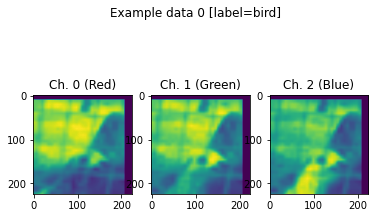

In [6]:
# Check the data
print(f'Train dataset length = {len(train_data_mini)}')
print(f'Valid dataset length = {len(valid_data_mini)}')
print(f'Test dataset length = {len(test_data_mini)}\n')

print(f'Classes = {test_data.classes}\n')

train_0_x, train_0_y = train_data_mini[0]
print(f'Label ({type(train_0_y).__name__}) = {train_0_y} ({test_data.classes[train_0_y]})')
print(f'Data ({type(train_0_x).__name__}) = {train_0_x.shape}\n')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Example data 0 [label={test_data.classes[train_0_y]}]')
ax1.imshow(train_0_x[0, :, :])
ax1.set_title('Ch. 0 (Red)')
ax2.imshow(train_0_x[1, :, :])
ax2.set_title('Ch. 1 (Green)')
ax3.imshow(train_0_x[2, :, :])
ax3.set_title('Ch. 2 (Blue)')
plt.show()

In [7]:
# Create data loader
train_loader = DataLoader(train_data_mini, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data_mini, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_data_mini, batch_size=batch_size, pin_memory=True)

Idx: 0 / X.shape = torch.Size([16, 3, 224, 224]) / Y.shape = torch.Size([16])

Y[0:16] = [3, 6, 0, 9, 6, 7, 0, 4, 1, 6, 4, 4, 8, 4, 6, 3]
→ Label = ['cat' 'frog' 'airplane' 'truck' 'frog' 'horse' 'airplane' 'deer'
 'automobile' 'frog' 'deer' 'deer' 'ship' 'deer' 'frog' 'cat']



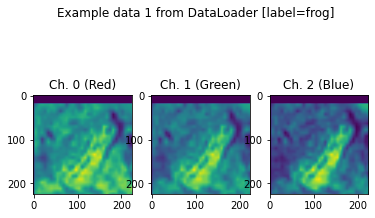

In [8]:
# Examine the data loader
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label.tolist()}')
print(f'→ Label = {np.array(test_data.classes)[ex_label]}\n')

preview_index = 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Example data {preview_index} from DataLoader [label={test_data.classes[ex_label[preview_index]]}]')
ax1.imshow(ex_data[preview_index, 0, :, :])
ax1.set_title('Ch. 0 (Red)')
ax2.imshow(ex_data[preview_index, 1, :, :])
ax2.set_title('Ch. 1 (Green)')
ax3.imshow(ex_data[preview_index, 2, :, :])
ax3.set_title('Ch. 2 (Blue)')
plt.show()

## 4. Function Definitions

Because our model is too simple now, we will use just `nn.Linear` module and wrap it with initializer function instead of defining a model class.

In [9]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# Model structure check
Summary(models.resnet18(pretrained = True).to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
# Model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def init_model(model_name, num_classes, feature_extract, use_pretrained=True):
    global net, loss_fn, optim
    
    # get CNN model from PyTorch Model Zoo
    if model_name == "resnet":
        """ Resnet18
        """
        net = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        net = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        net = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        net = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        net.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        net = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier.in_features
        net.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        net = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        # Handle the auxilary net
        num_ftrs = net.AuxLogits.fc.in_features
        net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Choose Model between [resnet, alexnet, vgg, squeezenet, densenet, inception]")
        return 
    
    net = net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)

    return input_size

In [12]:
# Memory cleaner to prevent CUDA out of memory error
def clear_memory():
    if device != 'cpu':
        empty_cache()
    garb_collected = gc.collect()

In [13]:
# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0


def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    # Clear memory to prevent CUDA memory error
    clear_memory()
    
    return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch

In [14]:
# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []


def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)


def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)


def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)

    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()

    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

## 5. Training Iteration & Result Analysis (Train the entire model)

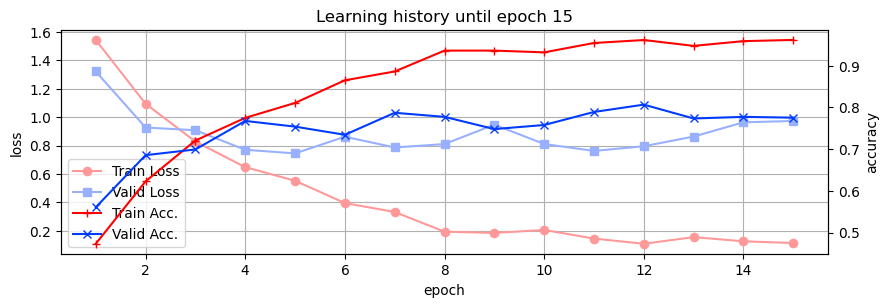

Iter:   15 >> T_loss 0.11516    T_acc 0.96174   V_loss 0.97281    V_acc 0.77539   🕒 4.692s
Iter:   14 >> T_loss 0.12726    T_acc 0.95885   V_loss 0.96339    V_acc 0.77734   🕒 4.697s
Iter:   13 >> T_loss 0.15664    T_acc 0.94751   V_loss 0.86311    V_acc 0.77344   🕒 4.700s
Iter:   12 >> T_loss 0.10986    T_acc 0.96152   V_loss 0.79523    V_acc 0.80664   🕒 4.692s
Iter:   11 >> T_loss 0.14663    T_acc 0.95440   V_loss 0.76240    V_acc 0.78906   🕒 4.686s
Iter:   10 >> T_loss 0.20687    T_acc 0.93194   V_loss 0.81104    V_acc 0.75781   🕒 4.689s
Iter:    9 >> T_loss 0.18602    T_acc 0.93617   V_loss 0.94686    V_acc 0.74805   🕒 4.678s
Iter:    8 >> T_loss 0.19507    T_acc 0.93617   V_loss 0.81043    V_acc 0.77734   🕒 4.676s
Iter:    7 >> T_loss 0.33332    T_acc 0.88612   V_loss 0.78668    V_acc 0.78711   🕒 4.661s
Iter:    6 >> T_loss 0.39596    T_acc 0.86499   V_loss 0.86203    V_acc 0.73438   🕒 4.676s
Iter:    5 >> T_loss 0.55281    T_acc 0.81072   V_loss 0.74491    V_acc 0.75391   🕒 4.653s

In [15]:
# Training Initialization
init_model(model_name='resnet', num_classes=10, feature_extract=False, use_pretrained=True)
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

# Accuracy for test dataset
with torch.no_grad():
    net.eval()
    test_loss, test_acc = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

## 6. Training Iteration & Result Analysis (Freeze the convlutional base)

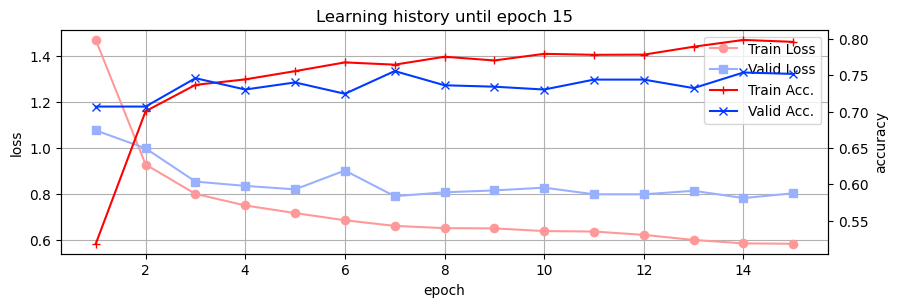

Iter:   15 >> T_loss 0.58538    T_acc 0.79604   V_loss 0.80454    V_acc 0.75195   🕒 1.702s
Iter:   14 >> T_loss 0.58721    T_acc 0.79871   V_loss 0.78363    V_acc 0.75391   🕒 1.703s
Iter:   13 >> T_loss 0.60205    T_acc 0.78937   V_loss 0.81527    V_acc 0.73242   🕒 1.702s
Iter:   12 >> T_loss 0.62395    T_acc 0.77847   V_loss 0.80002    V_acc 0.74414   🕒 1.704s
Iter:   11 >> T_loss 0.63856    T_acc 0.77825   V_loss 0.80008    V_acc 0.74414   🕒 1.702s
Iter:   10 >> T_loss 0.64051    T_acc 0.77958   V_loss 0.82885    V_acc 0.73047   🕒 1.701s
Iter:    9 >> T_loss 0.65219    T_acc 0.77046   V_loss 0.81682    V_acc 0.73438   🕒 1.703s
Iter:    8 >> T_loss 0.65320    T_acc 0.77558   V_loss 0.80868    V_acc 0.73633   🕒 1.698s
Iter:    7 >> T_loss 0.66300    T_acc 0.76468   V_loss 0.79172    V_acc 0.75586   🕒 1.699s
Iter:    6 >> T_loss 0.68741    T_acc 0.76779   V_loss 0.90320    V_acc 0.72461   🕒 1.701s
Iter:    5 >> T_loss 0.71859    T_acc 0.75578   V_loss 0.82138    V_acc 0.74023   🕒 1.703s

In [16]:
# Training Initialization
init_model(model_name='resnet', num_classes=10, feature_extract=True, use_pretrained=True)
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

# Accuracy for test dataset
with torch.no_grad():
    net.eval()
    test_loss, test_acc = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')